In [59]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import poppy
import skimage
from skimage.registration import phase_cross_correlation
import copy
from importlib import reload
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import multiprocessing

import subprocess
import glob
from pathlib import Path
import os
cwd = os.getcwd()

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

wavelength = 633e-9
fl = 425e-3
fsm_pupil_diam = 7.1e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(1/pxscl_lamD)

zero = np.array([[0,0,0]]).T
v_bias = np.array([[50,50,50]]).T

pxscl_lamD * as_per_lamD

def toggle_telem_campupil(on=True):
    client0.wait_for_properties(['telem_campupil.writing'])
    if on:
        client0[f'telem_campupil.writing.toggle'] = purepyindi.SwitchState.ON
    else:
        client0[f'telem_campupil.writing.toggle'] = purepyindi.SwitchState.OFF

def toggle_telem_fsm(on=True):
    client0.wait_for_properties(['telem_fsm.writing'])
    if on:
        client0[f'telem_fsm.writing.toggle'] = purepyindi.SwitchState.ON
    else:
        client0[f'telem_fsm.writing.toggle'] = purepyindi.SwitchState.OFF

18.389524275269295 arcsec
10.982853643600734


# Setup camera interface.

In [5]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [73]:
npsf = 50
cam.set_roi(570, 900, npsf, client0)

In [71]:
cam.set_exptime(0.0001, client0)

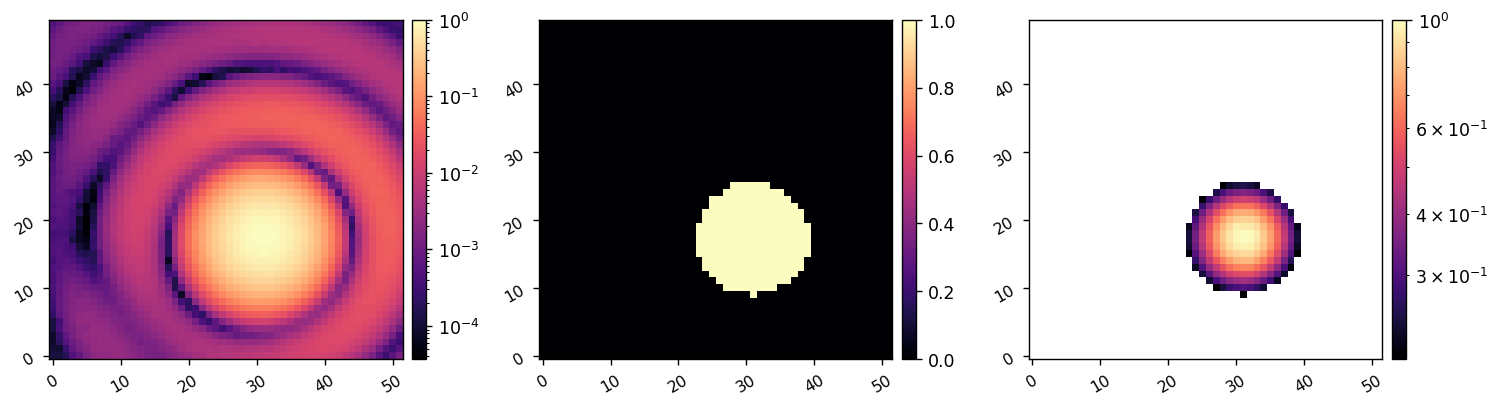

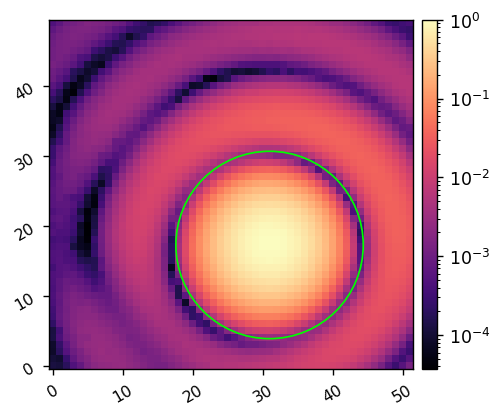

In [12]:
cam.Nframes = 1000
im_bias = cam.snap()

reload(utils)
cen = utils.centroid(im_bias, thresh=0.2, plot=True)
imshow1(im_bias, lognorm=True, patches=[Circle(cen, 1.22/pxscl_lamD, fill=False, color='lime')])


# Setup FSM Interface

In [98]:
fsm = ImageStream('fsm')

In [66]:
fsm.write(v_bias)

In [99]:
fsm.write(zero)

# Do a latency test.

In [88]:
# Setup the directories to which the FSM and campupil data will be stored.

exp_dir = 'latency-exp'

subprocess.run(['mkdir',f'{cwd}/data/{exp_dir}'])
subprocess.run(['mkdir',f'{cwd}/data/{exp_dir}/cam'])
subprocess.run(['mkdir',f'{cwd}/data/{exp_dir}/fsm'])

CompletedProcess(args=['mkdir', '/home/uasal/Projects/fsm-exps/data/latency-exp/fsm'], returncode=0)

In [19]:
# Define the FSM step amount
amp = 0.25*as_per_lamD
v_step = fsm_utils.get_fsm_volts(tip=amp, tilt=0*u.arcsec)
# v_step = fsm_utils.get_fsm_volts(tip=0*u.arcsec, tilt=amp)
# v_step = fsm_utils.get_fsm_volts(tip=amp/np.sqrt(2), tilt=amp/np.sqrt(2))
print(v_step)

[[50.77210434]
 [49.61394783]
 [49.61394783]]


In [89]:
# Do the latency test

toggle_telem_campupil(1)
# toggle_telem_fsm(1)
time.sleep(0.1)

# fsm.write(v_step)

time.sleep(0.1)
toggle_telem_campupil(0)
# toggle_telem_fsm(0)

# Extract and analyze the data from the test.

In [90]:
# Decompress the .xrif files from the telem_* apps into the desired data directories
subprocess.run(['xrif2fits','-d','/opt/MagAOX/telem/campupil/','-D',f'{cwd}/data/{exp_dir}/cam'])
clear_output()
# subprocess.run(['xrif2fits','-d','/opt/MagAOX/telem/fsm/','-D',f'{cwd}/data/{exp_dir}/fsm'])
# clear_output()

In [ ]:
# Remove the xrif data files 
# subprocess.run(['rm','-rf','/opt/MagAOX/telem/campupil/*'])
# subprocess.run(['rm','-rf','/opt/MagAOX/telem/fsm/*'])

In [91]:
import glob
from pathlib import Path

exp_dir = 'latency-exp'

dir_path = Path(f'{cwd}/data/{exp_dir}/cam')  # Replace with the actual directory path

fnames = sorted(glob.glob(str(dir_path/'*20250124*.fits')))
fnames

['/home/uasal/Projects/fsm-exps/data/latency-exp/cam/campupil_20250124195538183444616.fits',
 '/home/uasal/Projects/fsm-exps/data/latency-exp/cam/campupil_20250124195538183963067.fits',
 '/home/uasal/Projects/fsm-exps/data/latency-exp/cam/campupil_20250124195538184478114.fits',
 '/home/uasal/Projects/fsm-exps/data/latency-exp/cam/campupil_20250124195538185038350.fits',
 '/home/uasal/Projects/fsm-exps/data/latency-exp/cam/campupil_20250124195538185517280.fits',
 '/home/uasal/Projects/fsm-exps/data/latency-exp/cam/campupil_20250124195538186075110.fits',
 '/home/uasal/Projects/fsm-exps/data/latency-exp/cam/campupil_20250124195538186598598.fits',
 '/home/uasal/Projects/fsm-exps/data/latency-exp/cam/campupil_20250124195538187107427.fits',
 '/home/uasal/Projects/fsm-exps/data/latency-exp/cam/campupil_20250124195538187624586.fits',
 '/home/uasal/Projects/fsm-exps/data/latency-exp/cam/campupil_20250124195538188096571.fits',
 '/home/uasal/Projects/fsm-exps/data/latency-exp/cam/campupil_20250124

In [94]:
start_frame_time = float(fnames[0].split("_")[1][12:-5])/1e9
print(start_frame_time)

frames = []
times = []
for fname in fnames:
    frames.append(fits.getdata(fname))
    times.append(float(fname.split("_")[1][12:-5])/1e9)
frames = np.array(frames) 
times = np.array(times)
times = times - times[0]



38.183444616


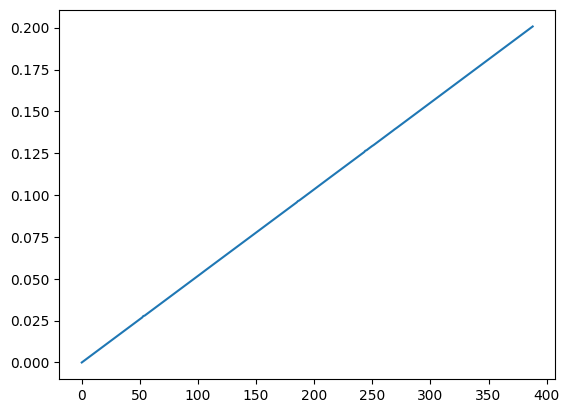

In [95]:
plt.plot(times)

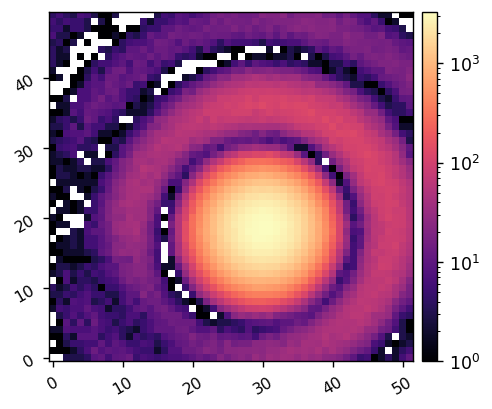

In [44]:
imshow1(frames[0], lognorm=True)

In [ ]:
times = []
for fname in fnames:
    times.append(float(fname[9:-5]))

In [50]:
time = fnames[-2][9:-5]
float(time)

2.0250123203552085e+22